# défi de reconnaissance d'émotions faciales de Kaggle en utilisant les CNN
Il est conseillé d'excuter ce notebook sur des GPU ou d'utiliser la plateforme kaggle https://www.kaggle.com/code/kassadiallo/cnn-emotion-classifier.

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

## Step1: Retrieve data

In [5]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test_with_emotions.csv")
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [6]:
df_train.shape

(28709, 2)

In [7]:
df_test.shape

(7178, 3)

In [8]:
df_train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [9]:
df_test.head()

,Unnamed: 0,emotion,pixels
0,0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,1,1,156 184 198 202 204 207 210 212 213 214 215 21...
2,2,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,3,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,4,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [10]:
def preprocess_pixels(pixels_str):
    pixel_values = np.array(pixels_str.split(), dtype=int)  
    return pixel_values.reshape(48, 48)
    
df_train['image'] = df_train['pixels'].apply(preprocess_pixels)
df_test['image'] = df_test['pixels'].apply(preprocess_pixels)
df_train["emotion"] = df_train["emotion"].apply(int)

In [11]:
df_train.head()

,emotion,pixels,image
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."


## Step 2 - Visualisation Emotion label

In [12]:
df_train["emotion"].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [13]:
emotion_percentage = (df_train["emotion"].value_counts() / len(df_train)) * 100

for emotion_idx, percentage in emotion_percentage.items():
    emotion_name = emotions[emotion_idx]  
    print(f"{emotion_name}: {percentage:.2f}%")


Happy: 25.13%
Neutral: 17.29%
Sad: 16.82%
Fear: 14.27%
Angry: 13.92%
Surprise: 11.05%
Disgust: 1.52%


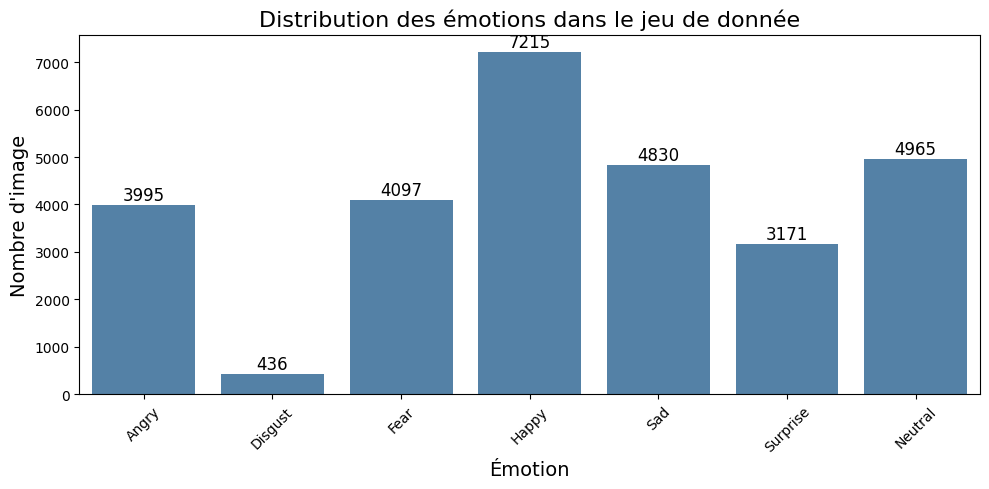

In [14]:
import seaborn as sns
emotion_counts = df_train['emotion'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, color='steelblue')
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.title('Distribution des émotions dans le jeu de donnée', fontsize=16)
plt.xlabel('Émotion', fontsize=14)
plt.ylabel('Nombre d\'image', fontsize=14)

for i, count in enumerate(emotion_counts.values):
    plt.text(i, count + 100, f"{count}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## Step3: Visualisation Image

In [15]:
def plot_emotion_samples(df, emotions, num_samples=5):
    """Affiche un échantillon d'images pour chaque émotion."""
    plt.figure(figsize=(16, 16))
    
    for row, (emotion, label) in enumerate(zip(np.unique(df["emotion"]), emotions)):
        emotion_imgs = df[df.emotion == emotion]
        sample_count = min(len(emotion_imgs), num_samples)  
        
        for i in range(sample_count):
            img = np.array(emotion_imgs.iloc[i]["image"], dtype=int)
            
            plt.subplot(len(emotions), num_samples, row * num_samples + i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            
            plt.text(24, 52, s=label, fontsize=12, color='blue', ha='center')

    plt.show()

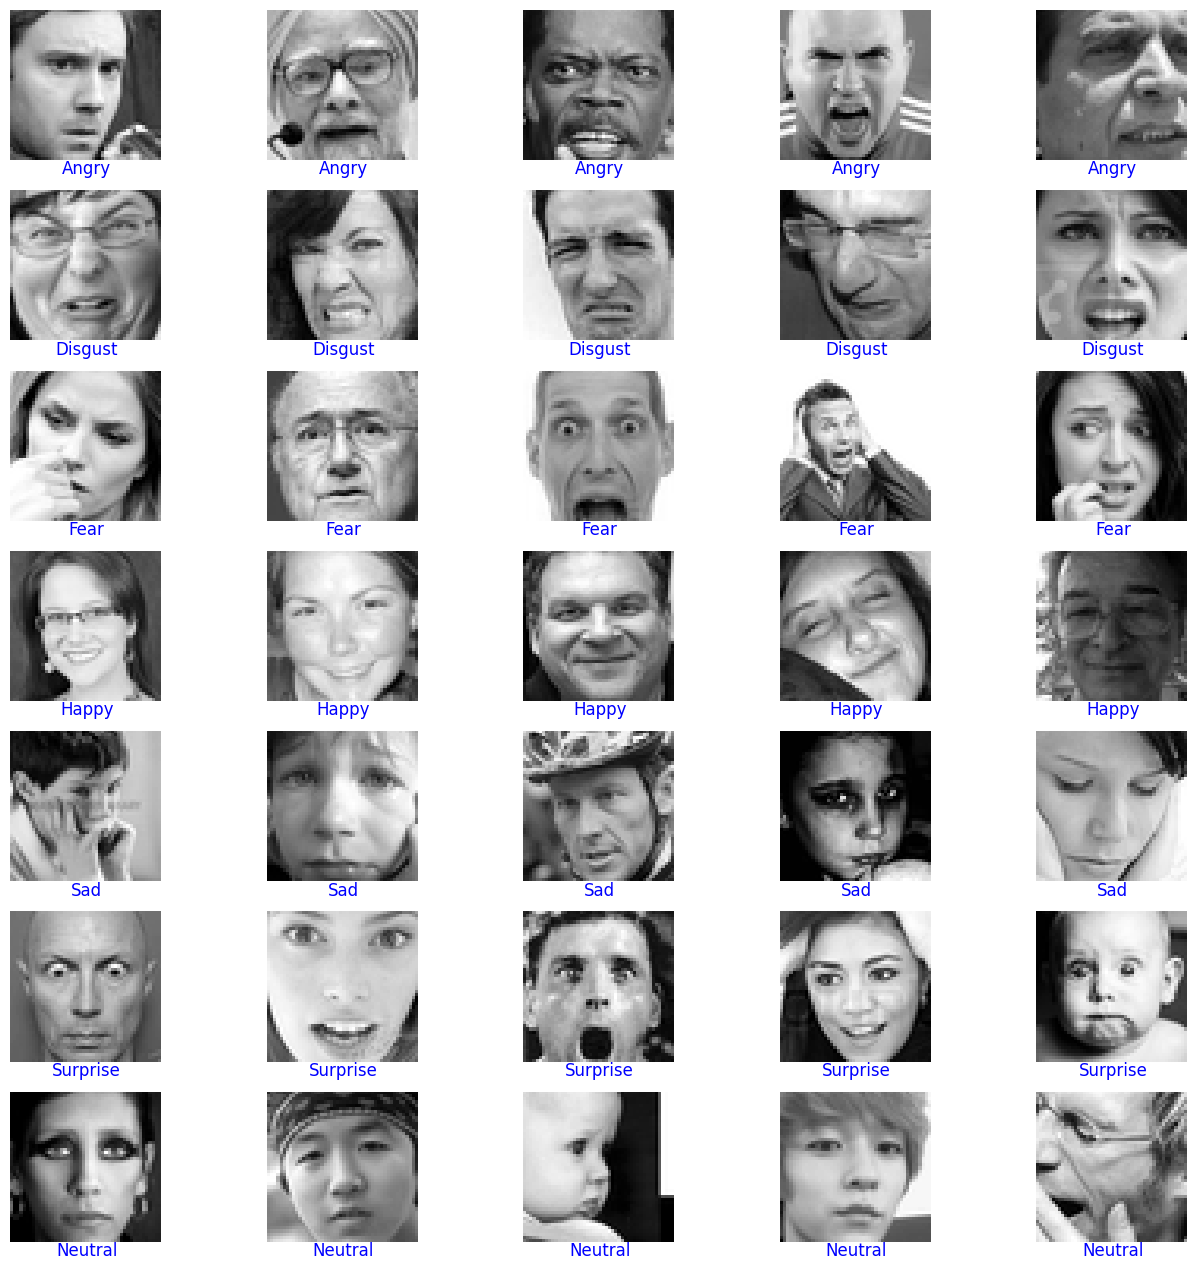

In [16]:
plot_emotion_samples(df_train, emotions)

# Step4: Preprocessing

On  effectue les process suivantes
- Conversion des images : Les pixels, initialement sous forme de texte, sont transformés en tableaux NumPy et redimensionnés en matrices 48x48.
- Normalisation : Les valeurs des pixels sont divisées par 255.0 pour les ramener dans une plage entre 0 et 1, ce qui améliore la stabilité du modèle.
Reshape des images : Une dimension supplémentaire est ajoutée ((nombre_images, 48, 48, 1)) pour être compatible avec les réseaux convolutifs (CNN).
- Encodage des labels : Les émotions, initialement sous forme d’entiers (0 à 6), sont converties en one-hot encoding, un format nécessaire pour la classification multi-classes.

In [17]:
def preprocess_data_for_cnn(df, num_classes=7):
    """Prétraitement des images et des labels pour l'entraînement du cnn."""
    # reshape dimensions
    X_list = df['pixels'].apply(lambda pixels_str: preprocess_pixels(pixels_str)).tolist()
    X = np.array(X_list)    
    # Normalisation
    X = X / 255.0  
    X = X.reshape(-1, 48, 48, 1) 
    # Reformater pour CNN    
    y = to_categorical(df["emotion"].astype(int), num_classes=num_classes)
    return X, y

In [18]:
X_train, y_train = preprocess_data_for_cnn(df_train)
X_test, y_test = preprocess_data_for_cnn(df_test)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=df_train["emotion"])

**ImageDataGenerator** permet d'effectuer de l'augmentation de données (data augmentation) en temps réel. Cela est particulièrement utile pour améliorer la généralisation du modèle et éviter le sur-apprentissage (overfitting), surtout lorsque le jeu de données est limité.

In [20]:
datagen = ImageDataGenerator(
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,      
    fill_mode='nearest'        
)

# Step5: Modelisation

Ce modèle est un réseau de neurones convolutionnel (CNN) conçu pour la classification d’images, en particulier pour reconnaître les émotions faciales. Voici une explication détaillée des différentes couches et de leur rôle :

**1. Convolution et Extraction de caractéristiques**
  - Première couche conv (32 filtres, 3x3)
    - Applique 32 filtres de taille 3x3 pour détecter les premiers motifs (bords,              textures).
    - Activation ReLU pour introduire la non-linéarité.
  - Deuxième couche conv (64 filtres, 3x3)
    - Approfondit l’extraction des caractéristiques.
    - Suivie d’une BatchNormalization pour stabiliser et accélérer l’apprentissage.
  - MaxPooling (2x2) & Dropout (0.25)
    - MaxPooling réduit la taille des cartes de caractéristiques (réduit le nombre de          paramètres et prévient l’overfitting).
    - Dropout (0.25) désactive aléatoirement 25% des neurones pour éviter l’overfitting.
      
**2. Couches Convolutionnelles plus profondes**
   - Conv2D (128 filtres) et Conv2D (256 filtres) avec régularisation L2
     - Augmente la complexité des caractéristiques apprises.
     - L2 Regularization (0.02) ajoute une pénalisation pour éviter que les poids du            réseau deviennent trop grands et donc sur-apprennent les données d’entraînement.
     - BatchNormalization + MaxPooling + Dropout (0.25)
     - Normalisation pour stabiliser l’entraînement.
     - Pooling pour réduire la taille des cartes de caractéristiques.
     - Dropout pour éviter le surapprentissage.
       
**3. Dernières couches convolutives et denses**

   Deux couches Conv2D avec 512 filtres
   Ces couches extraient des caractéristiques de haut niveau (expressions complexes du       visage).
   
**Flatten**

  Transforme les cartes de caractéristiques en un vecteur 1D.
  
**Dense (1024 neurones) + ReLU + Dropout (0.5)**

   - Couche entièrement connectée qui apprend des combinaisons complexes des                   caractéristiques extraites.
   - Dropout (0.5) pour éviter le surapprentissage.
  
  **4. Couche de sortie (Classification des émotions)**

   - Dense(num_classes) + Softmax
   La dernière couche a autant de neurones que le nombre de classes d’émotions.
   - Softmax convertit les scores en probabilités pour chaque classe.


In [21]:
img_width = 48
img_height = 48
batch_size  = 128
epochs      =  50
fit_verbosity = 1
num_classes = 7
learning_rate = 0.0001

In [22]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.02))) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.02))) 
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.02)))  
    model.add(Activation('relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.02))) 
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()
    return model

[Fine tunne model de classification d'image](https://medium.com/@roshankg96/transfer-learning-and-fine-tuning-model-using-vgg-16-90b5401e1ebd)

In [23]:
model = cnn_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

**EarlyStopping** : Arrête l'entraînement si la perte de validation (val_loss) ne s'améliore pas après un certain nombre d'époques (patience). Cela évite le sur-apprentissage et économise du temps.

Exemple : Si patience=5, l'entraînement s'arrête après 5 époques sans amélioration.


In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

**ReduceLROnPlateau** : Réduit automatiquement le taux d'apprentissage (learning rate) si la perte de validation stagne. Cela aide le modèle à mieux converger.

Exemple : Si patience=3 et factor=0.5, le learning rate est divisé par 2 après 3 époques sans amélioration.

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Step6: Entrainement du model

On compile le modèle en définissant :

- **Adam**, un optimiseur avancé qui combine momentum et adaptation du taux d’apprentissage.
- **Le learning_rate** pour contrôler la vitesse d’apprentissage.
- **Fonction de perte** : categorical_crossentropy, utilisée pour classification multi-classes (émotions).
Compare les prédictions (probabilités softmax) aux vraies étiquettes (one-hot encoded).
- **L'accurancy** : métrique qui permet d'évalue la performance du modèle en mesurant la proportion de prédictions correctes.

In [26]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs,
    verbose=fit_verbosity,
    callbacks=[early_stop, reduce_lr]
)

In [ ]:
model.save('final_emotion_model.keras')
print("Le modèle a été enregistré avec succès")

## Learning Curve

In [ ]:
losses=pd.DataFrame(history.history)

In [ ]:
losses[['loss','val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()
plt.grid(True)
plt.show()


On remarque que le gap de généralisation (l'écart de l'accurancy entre le le train set et le validation set) est petit. Ce qui permet de déduire que le model ne fait pas du overfitting ni du underfitting. Le model est capable de généraliser sur de nouvelles données.

In [ ]:
# Évaluer le modèle
print("shape X_test:", X_test.shape)
print("shape y_test:", y_test.shape)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Accuracy sur le test set : {test_acc:.4f}")

**Visualisations des images mal prédits**

In [ ]:
def visualize_misclassified_images(X_test, y_test, model, emotions, num_samples=15, max_columns=5):
    """Affiche des images mal prédites par le modèle sous forme de grille."""
    
    y_pred = model.predict(X_test)    
    misclassified_indices = np.where(np.argmax(y_pred, axis=1) != np.argmax(y_test, axis=1))[0]    
    num_samples = min(num_samples, len(misclassified_indices))
    
    num_rows = (num_samples + max_columns - 1) // max_columns
    
    plt.figure(figsize=(max_columns * 4, num_rows * 4))
    
    for i in range(num_samples):
        index = misclassified_indices[i]
        
        # Image mal prédite
        img = X_test[index].reshape(48, 48)  
        true_label = emotions[np.argmax(y_test[index])]  
        predicted_label = emotions[np.argmax(y_pred[index])]  
        
        plt.subplot(num_rows, max_columns, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
        plt.title(f"True: {true_label}", fontsize=18, color='blue', pad=20)  
        plt.text(24, -8, f"Pred: {predicted_label}", fontsize=16, color='red', ha='center')  
    
    plt.tight_layout(pad=3.0)  

visualize_misclassified_images(X_test, y_test, model, emotions, num_samples=10, max_columns=5)


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
df = pd.DataFrame(y_pred_classes, columns=['3'])  
df.to_csv("submission.csv", index=False, header=True)
print("✅ Fichier submission.csv enregistré avec succès !")
df.head()
